In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
import cv2
import glob
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

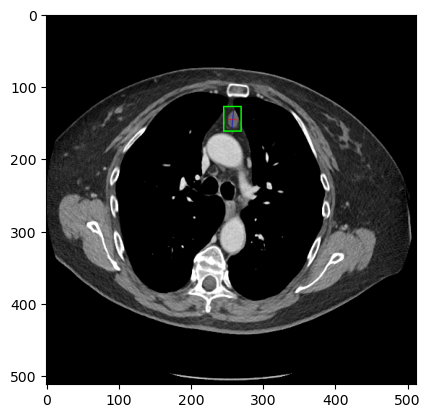

In [18]:
image=cv2.imread("C:/Users/kavin/cancer_ct_GLCM/Test cases/000001_03_01_088.png")

from matplotlib import pyplot as plt
plt.imshow(image)
 

In [22]:
train_dir = 'C:/Users/kavin/cancer_ct_GLCM/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/*'
test_dir = 'C:/Users/kavin/cancer_ct_GLCM/Test cases/*'

In [25]:
SIZE = 140
BATCH_SIZE = 64
TARGET_SIZE = (SIZE,SIZE)
EPOCH_NUM = 10

In [28]:
categories_dict = {
  2: "Normal cases",
  1: "Malignant cases",
  0: "Bengin cases"
}

In [33]:
train_images = []
train_labels = [] 
label = 0

#Importing the first training dataset

for directory_path in glob.glob(train_dir):
    assert categories_dict[label] == os.path.normpath(directory_path).split(os.path.sep)[-1]
    print(categories_dict[label])
    counter = 1
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if(counter%200==0): print(counter,"images loaded")
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        train_images.append(img)
        train_labels.append(label)
        counter+=1
        if(counter%1500==0): break
    
    print(counter,"images loaded")
    label +=1
    
#Importing the additional training dataset

print("additional",categories_dict[2],"data")    
addit_counter = 1
x_train = np.array(train_images)
y_train = to_categorical(train_labels, 3)
  

Bengin cases
121 images loaded
Malignant cases
200 images loaded
400 images loaded
562 images loaded
Normal cases
200 images loaded
400 images loaded
417 images loaded
additional Normal cases data


In [54]:
test_images = []
test_labels = []
label = 0

# Path to your test data folder containing images
test_data_dir = 'C:\\Users\\kavin\\cancer_ct_GLCM\\Test cases'

# Check if the directory exists and is accessible
if not os.path.exists(test_data_dir):
    print(f"Directory {test_data_dir} does not exist.")
else:
    print(f"Loading images from {test_data_dir}...")

    # List all files in the directory
    files = glob.glob(os.path.join(test_data_dir, "*"))
    if not files:
        print(f"No files found in directory {test_data_dir}.")
    else:
        print(f"Found {len(files)} files in directory {test_data_dir}.")

    counter = 1
    for img_path in glob.glob(os.path.join(test_data_dir, "*.png")):
        #print(f"Processing image: {img_path}")  # Debug: print each image path
        if counter % 100 == 0:
            print(counter, "images loaded")
        img = cv2.imread(img_path, 0)
        if img is None:
            print(f"Failed to load image: {img_path}")  # Debug: check if the image was loaded correctly
            continue
        # Set TARGET_SIZE to the desired size, e.g., (224, 224)
        TARGET_SIZE = (224, 224)  
        img = cv2.resize(img, TARGET_SIZE)
        test_images.append(img)
        # Assign a label (modify as needed)
        test_labels.append(label)
        counter += 1

    print(counter - 1, "images loaded")  # -1 to exclude the initial value of counter

    test_images = np.array(test_images)
    # Assuming there are 3 classes, adjust the number if needed
    test_labels = to_categorical(test_labels, 3)

    print("Data loading complete.")
    print(f"Total images loaded: {len(test_images)}")

Loading images from C:\Users\kavin\cancer_ct_GLCM\Test cases...
Found 197 files in directory C:\Users\kavin\cancer_ct_GLCM\Test cases.
100 images loaded
197 images loaded
Data loading complete.
Total images loaded: 197


In [57]:
train_test_split(train_images, train_labels)
train_images, val_images, train_labels, val_labels = train_test_split(x_train, y_train, test_size=0.15, random_state=69)

In [60]:
print("train:",train_images.shape[0],", test:",test_images.shape[0],", val:",val_images.shape[0])

train: 932 , test: 197 , val: 165


In [63]:
def feature_extractor(images):
    image_dataset = pd.DataFrame()
    for image in images:   
        df = pd.DataFrame()
        
        #greycomatrix(image, distances, angles, levels=256, symmetric=False, normed=False)
        #distances - List of pixel pair distance offsets.
        #angles - List of pixel pair angles in radians.
        
        #5 configuration for the grey-level co-occurrence matrix calculation
        dists = [[1],[3],[5],[3],[3]]
        angles = [[0],[0],[0],[np.pi/4],[np.pi/2]]
        
        for n ,(dist, angle) in enumerate(zip(dists, angles)):
        
            GLCM = graycomatrix(image, dist, angle)       
            GLCM_Energy = graycoprops(GLCM, 'energy')[0]
            df['Energy'+str(n)] = GLCM_Energy
            GLCM_corr = graycoprops(GLCM, 'correlation')[0]
            df['Corr'+str(n)] = GLCM_corr       
            GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
            df['Diss_sim'+str(n)] = GLCM_diss       
            GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
            df['Homogen'+str(n)] = GLCM_hom       
            GLCM_contr = graycoprops(GLCM, 'contrast')[0]
            df['Contrast'+str(n)] = GLCM_contr

        image_dataset = pd.concat([image_dataset, df], ignore_index=True)
        
    return image_dataset

In [66]:
train_extr_features = feature_extractor(train_images)

In [68]:
test_extr_features = feature_extractor(test_images)

In [71]:
val_extr_features = feature_extractor(val_images)

In [73]:
type(train_images)
# convert from integers to floats
train_images_norm = train_images.astype('float32')
test_images_norm = test_images.astype('float32')
val_images_norm = val_images.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

In [76]:
pd.set_option("display.max_columns", None)
train_extr_features

,Energy0,Corr0,Diss_sim0,Homogen0,Contrast0,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy4,Corr4,Diss_sim4,Homogen4,Contrast4
0,0.199892,0.904106,16.486588,0.254285,863.369322,0.181229,0.816474,21.533160,0.236159,1663.157769,0.164639,0.758262,25.456243,0.212370,2206.132646,0.177789,0.791115,23.143982,0.229044,1898.120668,0.181116,0.775558,23.749844,0.233541,2033.910740
1,0.154634,0.947093,9.540185,0.305678,547.674306,0.139662,0.837253,17.029249,0.283357,1698.299844,0.126221,0.757270,22.739788,0.261423,2552.831429,0.138115,0.791471,19.803455,0.276901,2184.318578,0.139398,0.758355,21.986966,0.274866,2521.516684
2,0.191640,0.958382,7.737461,0.401351,461.388643,0.174380,0.863158,15.344838,0.365773,1527.710636,0.158791,0.798250,20.605714,0.334294,2268.314074,0.171575,0.830675,17.651596,0.355475,1896.720489,0.174247,0.819041,18.557560,0.349854,2020.449635
3,0.028883,0.958042,11.678931,0.140427,430.399075,0.025332,0.874004,18.359854,0.127274,1294.647967,0.023044,0.809545,23.547831,0.113537,1960.505291,0.024784,0.840120,20.744539,0.118958,1643.182367,0.024629,0.817501,22.499374,0.117815,1874.042231
4,0.045848,0.958708,10.547945,0.184541,497.148458,0.042470,0.852738,19.194213,0.172717,1780.357091,0.040188,0.773514,25.751958,0.154379,2747.491534,0.041478,0.805059,22.612161,0.164236,2360.544003,0.040997,0.785023,24.317414,0.160345,2597.969343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,0.037340,0.954232,10.994090,0.241063,590.042703,0.032667,0.834222,22.793170,0.176750,2127.512669,0.030212,0.725627,31.789947,0.143568,3507.586878,0.031355,0.837356,22.576560,0.166026,2086.133165,0.031175,0.837981,22.820386,0.164034,2086.243326
928,0.132551,0.948707,8.168859,0.366900,510.195478,0.119836,0.828794,16.608342,0.330659,1714.859437,0.108951,0.745385,22.656931,0.303129,2564.999259,0.118224,0.805630,18.346303,0.319506,1954.526307,0.118262,0.791649,19.480136,0.310364,2087.765537
929,0.138902,0.956782,7.811871,0.417549,478.405293,0.127331,0.854586,16.144943,0.369228,1618.831387,0.116832,0.786296,21.915185,0.329813,2391.777302,0.124777,0.826598,18.472012,0.349067,1937.325089,0.124358,0.807866,20.122993,0.336077,2140.328415
930,0.227986,0.966451,6.276567,0.541651,335.690956,0.207323,0.882854,13.339051,0.467819,1181.426434,0.189708,0.812919,18.698836,0.422890,1901.797566,0.203220,0.861441,15.196860,0.449181,1402.555818,0.205061,0.851089,16.161940,0.433020,1501.778936


In [79]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate

def build_mlp():
    inputs = Input(shape=(25,), name='Extracted_Traditional_Features')
    x = Dense(8, activation='relu', name='Dense1')(inputs)
    x = Dense(4, activation='relu', name='Dense2')(x)
    model = Model(inputs=inputs, outputs=x)
    print(model.summary())
    return model

def build_cnn():
    inputs = Input(shape=(140, 140, 1), name='Original_Images')
    x = Conv2D(filters=32, kernel_size=11, strides=1, activation='relu', name='Conv1')(inputs)
    x = Conv2D(filters=32, kernel_size=11, strides=1, activation='relu', name='Conv2')(x)
    x = MaxPooling2D(pool_size=(5, 5), strides=2)(x)
    x = Conv2D(filters=64, kernel_size=9, strides=1, activation='relu', name='Conv3')(x)
    x = MaxPooling2D(pool_size=(5, 5), strides=2)(x)
    x = Conv2D(filters=128, kernel_size=8, strides=1, activation='relu', name='Conv4')(x)
    x = Conv2D(filters=256, kernel_size=9, strides=1, activation='relu', name='Conv5')(x)
    x = Conv2D(filters=256, kernel_size=8, strides=1, activation='relu', name='Conv6')(x)
    x = Flatten()(x)
    x = Dense(8, activation='relu', name='Dense')(x)
    model = Model(inputs=inputs, outputs=x)
    print(model.summary())
    return model

mlp = build_mlp()
cnn = build_cnn()

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(8, activation="relu")(combinedInput)
x = Dense(3, activation="softmax")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Extracted_Traditional_Features  │ (None, 25)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 8)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244 (976.00 B)

 Trainable params: 244 (976.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Original_Images (InputLayer)    │ (None, 140, 140, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 130, 130, 32)   │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 120, 120, 32)   │       123,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 50, 50, 64)     │       165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 16, 16, 128)    │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 8, 8, 256)      │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 1, 1, 256)      │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,669,288 (29.26 MB)

 Trainable params: 7,669,288 (29.26 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Original_Images     │ (None, 140, 140,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 130, 130,  │      3,904 │ Original_Images[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 120, 120,  │    123,936 │ Conv1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 58, 58,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv3 (Conv2D)      │ (None, 50, 50,    │    165,952 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 23, 23,    │          0 │ Conv3[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv4 (Conv2D)      │ (None, 16, 16,    │    524,416 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv5 (Conv2D)      │ (None, 8, 8, 256) │  2,654,464 │ Conv4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Extracted_Traditio… │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv6 (Conv2D)      │ (None, 1, 1, 256) │  4,194,560 │ Conv5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense1 (Dense)      │ (None, 8)         │        208 │ Extracted_Tradit… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 256)       │          0 │ Conv6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense2 (Dense)      │ (None, 4)         │         36 │ Dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense (Dense)       │ (None, 8)         │      2,056 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12)        │          0 │ Dense2[0][0],     │
│ (Concatenate)       │                   │            │ Dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │         27 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,669,663 (29.26 MB)

 Trainable params: 7,669,663 (29.26 MB)

 Non-trainable params: 0 (0.00 B)

None


In [82]:
opt = keras.optimizers.Adam(learning_rate=0.005)

In [85]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-8,
        verbose=1,
    )
]

In [88]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Prepare dataset
dataset_inputs = tf.data.Dataset.from_tensor_slices((train_extr_features, tf.expand_dims(train_images_norm, axis=-1)))
dataset_label = tf.data.Dataset.from_tensor_slices(train_labels)
dataset = tf.data.Dataset.zip((dataset_inputs, dataset_label)).batch(BATCH_SIZE).repeat()

# Calculate steps per epoch
STEP_SIZE_TRAIN = train_images_norm.shape[0] // BATCH_SIZE

# Fit the model
history = model.fit(
    dataset, 
    validation_data=([val_extr_features, tf.expand_dims(val_images_norm, axis=-1)], val_labels),
    epochs=EPOCH_NUM, 
    steps_per_epoch=STEP_SIZE_TRAIN, 
    callbacks=cb
)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5055 - loss: 85.2603 - val_accuracy: 0.3818 - val_loss: 25.1051 - learning_rate: 0.0010
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.4569 - loss: 17.5003 - val_accuracy: 0.4242 - val_loss: 14.8863 - learning_rate: 0.0010
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4185 - loss: 12.6138 - val_accuracy: 0.3818 - val_loss: 10.3525 - learning_rate: 0.0010
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.4177 - loss: 9.0017 - val_accuracy: 0.4000 - val_loss: 9.5121 - learning_rate: 0.0010
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.4444 - loss: 7.8787 - val_accuracy: 0.3818 - val_loss: 7.7943 - learning_rate: 0.0010
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.4604 - loss: 6.7950 - val_accuracy: 0.4485 - val_loss: 6.9415 - learning_rate: 0.0010
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.4357 - loss: 6.8397 - val_accu

In [90]:
model.save_weights('./kentang_net.weights.h5')


In [96]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_images_norm, test_labels))
test_dataset = test_inputs.batch(BATCH_SIZE)

# Calculate step size
STEP_SIZE_TEST = len(test_images_norm) // BATCH_SIZE

# Evaluate the model
score = model.evaluate(test_dataset, steps=STEP_SIZE_TEST)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

ValueError: Layer "functional_2" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224) dtype=float32>]

In [98]:
import matplotlib.pyplot as plt
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

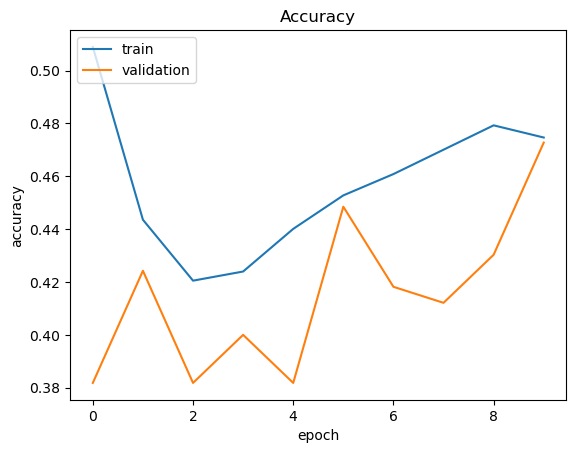

In [100]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
